In [1]:
!wget http://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz -O /content/mpii_full.tar.gz
!wget http://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip -O /content/mpii_ann.zip
!unzip /content/mpii_ann.zip -d /content/mpii_ann

--2025-04-13 00:05:29--  http://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.206.177
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz [following]
--2025-04-13 00:05:29--  https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12088943206 (11G) [application/x-gzip]
Saving to: ‘/content/mpii_full.tar.gz’

/content/mpii_full. 100%[===================>]  11.26G   102MB/s    in 2m 16s  

2025-04-13 00:07:45 (84.7 MB/s) - ‘/content/mpii_full.tar.gz’ saved [12088943206/12088943206]

URL transformed to HTTPS due to an 

In [2]:
!pip install torch torchvision opencv-python numpy tqdm scikit-learn scipy gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
!tar -xzf /content/mpii_full.tar.gz -C /content/

In [4]:
!ls /content/images/ | head -n 5

000001163.jpg
000003072.jpg
000004812.jpg
000005283.jpg
000013469.jpg


In [5]:
!ls /content/mpii_ann/mpii_human_pose_v1_u12_2/

bsd.txt  mpii_human_pose_v1_u12_1.mat  README.md


In [6]:
# !mkdir -p /content/mpii_subset/images

In [7]:
# Clear existing subset directory
# !rm -rf /content/mpii_subset/images/
# !mkdir -p /content/mpii_subset/images/

# !ls /content/images/*.jpg | head -n 5000 | xargs -I {} cp {} /content/mpii_subset/images/

# # Verify
# !ls /content/mpii_subset/images/ | wc -l

In [8]:
import os
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as transforms

# Define paths
image_dir = '/content/images/'  # Use full dataset
ann_file = '/content/mpii_ann/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'

# Load annotations
data = scipy.io.loadmat(ann_file)
RELEASE = data['RELEASE']
img_train = RELEASE['img_train'][0, 0][0]
annolist = RELEASE['annolist'][0, 0][0]

# Extract all annotated training images first
annotated_data = []
for idx, anno in enumerate(annolist):
    img_name = anno['image']['name'][0, 0][0]
    if img_train[idx] == 1:  # Training images only
        joints = []
        if 'annorect' in anno.dtype.names and anno['annorect'].size > 0 and anno['annorect'][0, 0] is not None:
            annorect = anno['annorect'][0, 0]
            if 'annopoints' in annorect.dtype.names and annorect['annopoints'].size > 0:
                if annorect['annopoints'][0, 0].size > 0 and annorect['annopoints'][0, 0][0] is not None:
                    annopoints = annorect['annopoints'][0, 0][0]
                    x = annopoints['x'][0] if 'x' in annopoints.dtype.names else []
                    y = annopoints['y'][0] if 'y' in annopoints.dtype.names else []
                    vis = annopoints['is_visible'][0] if 'is_visible' in annopoints.dtype.names else np.ones_like(x) * -1
                    if x.size > 0 and y.size > 0:
                        vis_numeric = np.array([int(v.item()) if v.size > 0 else -1 for v in vis], dtype=int)
                        joints = np.stack((x.flatten(), y.flatten(), vis_numeric), axis=-1)
        if len(joints) > 0:  # Only include images with joints
            img_size = anno['image'].get('size', [1000, 1000])[0, 0] if 'size' in anno['image'].dtype.names else [1000, 1000]
            annotated_data.append({
                'image': os.path.join(image_dir, img_name),
                'joints': joints,
                'img_size': img_size
            })

# Randomly sample exactly 10,000 annotated images (or all if less than 10,000)
np.random.seed(42)  # For reproducibility
if len(annotated_data) > 10000:
    subset_data = np.random.choice(annotated_data, 10000, replace=False).tolist()
else:
    subset_data = annotated_data
    print(f"Warning: Only {len(subset_data)} annotated training images available, using all.")

# Split into train (80%) and valid (20%)
train_size = int(0.8 * len(subset_data))
train_data = subset_data[:train_size]
valid_data = subset_data[train_size:]
print(f"Train data size: {len(train_data)}")
print(f"Valid data size: {len(valid_data)}")

Train data size: 8000
Valid data size: 2000


In [9]:
# Define transforms for faster processing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),  # Smaller size for speed
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class CustomMPIIDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        self.data = data
        self.train = train
        self.transform = transform
        self.num_joints = 16
        self.heatmap_size = (32, 32)  # Adjusted for 128x128 input
        self.sigma = 1.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['image']
        joints = self.data[idx]['joints']
        img_size = self.data[idx].get('img_size', [1000, 1000])

        if joints.size > 0:
            if joints.ndim == 1:
                joints = joints.reshape(-1, 3)
            joints = np.array([[float(j[0].item() if hasattr(j[0], 'item') else j[0]),
                                float(j[1].item() if hasattr(j[1], 'item') else j[1]),
                                float(j[2].item() if hasattr(j[2], 'item') else j[2])]
                              for j in joints], dtype=np.float32)
        else:
            joints = np.zeros((self.num_joints, 3), dtype=np.float32)

        joints_padded = np.full((self.num_joints, 3), -1, dtype=np.float32)
        num_annotated = min(joints.shape[0], self.num_joints)
        if num_annotated > 0:
            joints_padded[:num_annotated] = joints[:num_annotated]

        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image at {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)

        heatmaps = self.generate_heatmaps(joints_padded, img_size)
        weights = (joints_padded[:, 2] >= 0).astype(np.float32)

        return img, torch.tensor(heatmaps), torch.tensor(weights)

    def generate_heatmaps(self, joints, img_size):
        heatmaps = np.zeros((self.num_joints, *self.heatmap_size), dtype=np.float32)
        orig_width, orig_height = img_size
        for i, (x, y, vis) in enumerate(joints):
            if vis >= 0:
                x_scaled = int((x / orig_width) * self.heatmap_size[1])
                y_scaled = int((y / orig_height) * self.heatmap_size[0])
                if 0 <= x_scaled < self.heatmap_size[1] and 0 <= y_scaled < self.heatmap_size[0]:
                    heatmaps[i] = self.gaussian_heatmap(x_scaled, y_scaled)
        return heatmaps

    def gaussian_heatmap(self, x, y):
        heatmap = np.zeros(self.heatmap_size, dtype=np.float32)
        for i in range(self.heatmap_size[0]):
            for j in range(self.heatmap_size[1]):
                dist_sq = (i - y) ** 2 + (j - x) ** 2
                heatmap[i, j] = np.exp(-dist_sq / (2 * self.sigma ** 2))
        return heatmap

# Create datasets and loaders
train_dataset = CustomMPIIDataset(train_data, train=True, transform=train_transform)
valid_dataset = CustomMPIIDataset(valid_data, train=False, transform=valid_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")

Train batches: 250, Valid batches: 63


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
import torch.nn as nn

# Define a simplified HRNet for speed
class SimpleHRNet(nn.Module):
    def __init__(self, num_joints=16, width=32):
        super(SimpleHRNet, self).__init__()
        self.num_joints = num_joints
        # Initial convolutions with downsampling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # 128 -> 64
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)  # 64 -> 32
        self.bn2 = nn.BatchNorm2d(32)
        # Single stage for speed
        self.stage = self.make_stage(32, width, num_blocks=2)
        self.final_layer = nn.Conv2d(width, num_joints, kernel_size=1)

    def make_stage(self, in_channels, out_channels, num_blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_blocks - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # 128 -> 64
        x = self.relu(self.bn2(self.conv2(x)))  # 64 -> 32
        x = self.stage(x)  # 32x32
        x = self.final_layer(x)  # 32x32, num_joints channels
        return x

# Initialize model
model = SimpleHRNet(num_joints=16, width=32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Model initialized.")

Model initialized.


Epoch 1/20 (Valid): 100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


Epoch 1, Train Loss: 0.007607, Valid Loss: 0.004719, LR: 0.001000


Epoch 2/20 (Valid): 100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


Epoch 2, Train Loss: 0.004664, Valid Loss: 0.004652, LR: 0.001000


Epoch 3/20 (Valid): 100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


Epoch 3, Train Loss: 0.004611, Valid Loss: 0.004617, LR: 0.001000


Epoch 4/20 (Valid): 100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Epoch 4, Train Loss: 0.004589, Valid Loss: 0.004606, LR: 0.001000


Epoch 5/20 (Valid): 100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


Epoch 5, Train Loss: 0.004572, Valid Loss: 0.004607, LR: 0.001000


Epoch 6/20 (Valid): 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


Epoch 6, Train Loss: 0.004566, Valid Loss: 0.004588, LR: 0.001000


Epoch 7/20 (Valid): 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]


Epoch 7, Train Loss: 0.004562, Valid Loss: 0.004586, LR: 0.001000


Epoch 8/20 (Valid): 100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Epoch 8, Train Loss: 0.004556, Valid Loss: 0.004577, LR: 0.001000


Epoch 9/20 (Valid): 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


Epoch 9, Train Loss: 0.004553, Valid Loss: 0.004580, LR: 0.001000


Epoch 10/20 (Valid): 100%|██████████| 63/63 [01:32<00:00,  1.46s/it]


Epoch 10, Train Loss: 0.004548, Valid Loss: 0.004579, LR: 0.000100


Epoch 11/20 (Valid): 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


Epoch 11, Train Loss: 0.004540, Valid Loss: 0.004565, LR: 0.000100


Epoch 12/20 (Valid): 100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


Epoch 12, Train Loss: 0.004539, Valid Loss: 0.004565, LR: 0.000100


Epoch 13/20 (Valid): 100%|██████████| 63/63 [01:34<00:00,  1.51s/it]


Epoch 13, Train Loss: 0.004539, Valid Loss: 0.004564, LR: 0.000100


Epoch 14/20 (Valid): 100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


Epoch 14, Train Loss: 0.004539, Valid Loss: 0.004563, LR: 0.000100


Epoch 15/20 (Valid): 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


Epoch 15, Train Loss: 0.004538, Valid Loss: 0.004562, LR: 0.000100


Epoch 16/20 (Valid): 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


Epoch 16, Train Loss: 0.004538, Valid Loss: 0.004563, LR: 0.000100


Epoch 17/20 (Valid): 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


Epoch 17, Train Loss: 0.004537, Valid Loss: 0.004562, LR: 0.000100


Epoch 18/20 (Valid): 100%|██████████| 63/63 [01:34<00:00,  1.49s/it]


Epoch 18, Train Loss: 0.004537, Valid Loss: 0.004563, LR: 0.000100


Epoch 19/20 (Valid): 100%|██████████| 63/63 [01:34<00:00,  1.49s/it]


Epoch 19, Train Loss: 0.004538, Valid Loss: 0.004563, LR: 0.000100


Epoch 20/20 (Valid): 100%|██████████| 63/63 [01:37<00:00,  1.54s/it]


Epoch 20, Train Loss: 0.004536, Valid Loss: 0.004560, LR: 0.000010


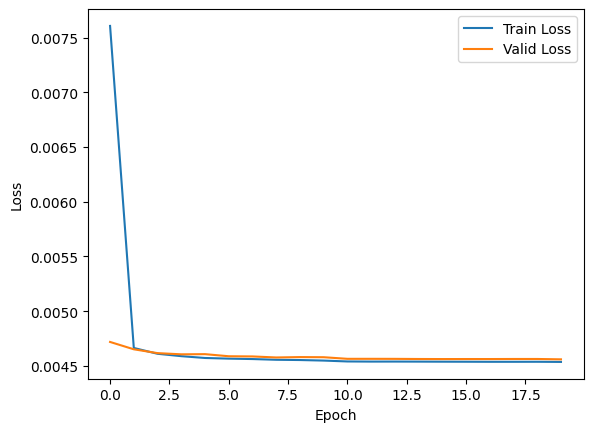

In [11]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training setup
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, heatmaps, weights in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
        images, heatmaps, weights = images.to(device), heatmaps.to(device), weights.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        loss = (loss * weights.unsqueeze(-1).unsqueeze(-1)).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for images, heatmaps, weights in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Valid)"):
            images, heatmaps, weights = images.to(device), heatmaps.to(device), weights.to(device)
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            loss = (loss * weights.unsqueeze(-1).unsqueeze(-1)).mean()
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    scheduler.step()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Evaluation function
def evaluate_model(model, data_loader, threshold=10):
    model.eval()
    pck_total = 0
    l2_total = 0
    total_joints = 0

    with torch.no_grad():
        for images, heatmaps, weights in data_loader:
            images, heatmaps, weights = images.to(device), heatmaps.to(device), weights.to(device)
            outputs = model(images)
            pred_coords = torch.argmax(outputs.view(outputs.size(0), outputs.size(1), -1), dim=2)
            pred_x = (pred_coords % 32) * 4  # 32 -> 128
            pred_y = (pred_coords // 32) * 4  # 32 -> 128
            gt_coords = torch.argmax(heatmaps.view(heatmaps.size(0), heatmaps.size(1), -1), dim=2)
            gt_x = (gt_coords % 32) * 4
            gt_y = (gt_coords // 32) * 4

            for i in range(images.size(0)):
                for j in range(16):
                    if weights[i, j] > 0:
                        dist = torch.sqrt((pred_x[i, j] - gt_x[i, j])**2 + (pred_y[i, j] - gt_y[i, j])**2)
                        pck_total += (dist <= threshold).float().item()
                        l2_total += dist.item()
                        total_joints += 1

    pck = pck_total / total_joints * 100 if total_joints > 0 else 0
    l2_error = l2_total / total_joints if total_joints > 0 else 0
    return pck, l2_error

# Run evaluation
pck, l2_error = evaluate_model(model, valid_loader)
print(f"Average PCK@10px across validation set: {pck:.2f}%")
print(f"Average Mean L2 Error across validation set: {l2_error:.2f} pixels")

Average PCK@10px across validation set: 3.31%
Average Mean L2 Error across validation set: 54.76 pixels


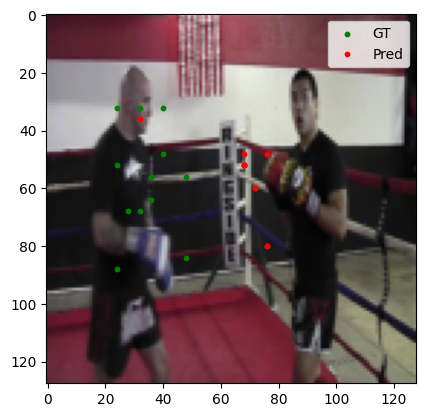

In [13]:
# Visualization function
def visualize_prediction(model, data_loader, idx=0):
    model.eval()
    images, heatmaps, weights = next(iter(data_loader))
    images, heatmaps = images.to(device), heatmaps.to(device)
    outputs = model(images)
    pred_coords = torch.argmax(outputs[0].view(16, -1), dim=1)
    pred_x = (pred_coords % 32) * 4
    pred_y = (pred_coords // 32) * 4
    gt_coords = torch.argmax(heatmaps[0].view(16, -1), dim=1)
    gt_x = (gt_coords % 32) * 4
    gt_y = (gt_coords // 32) * 4

    img = images[0].cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    for i in range(16):
        if weights[0, i] > 0:
            plt.scatter(gt_x[i].item(), gt_y[i].item(), c='g', s=10, label='GT' if i == 0 else "")
            plt.scatter(pred_x[i].item(), pred_y[i].item(), c='r', s=10, label='Pred' if i == 0 else "")
    plt.legend()
    plt.show()

# Visualize a sample
visualize_prediction(model, valid_loader)